# Drive mount

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("./drive/MyDrive/git_project/AnomalyDetection/src")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install requirement

In [2]:
!pip install -r ../requirements.txt
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c pytorch faiss-gpu -y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 81.4 MB/s eta 0:00:00
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
  Using cached timm-0.6.12-py3-none-any.whl (549 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 113.1 MB/s eta 0:00:00
  Using cached pytorch_lightning-1.9.4-py3-none-any.whl (827 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 119.4 MB/s eta 0:00:00
  Using cached segmentation_models_pytorch-0.3.3-py3-none-any.whl (106 kB)
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 37.3 MB/s eta 0:00:00
  Using cached munch-4.0.0-py2.py3-none-any.whl (9.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 66.6 MB/s eta 0:00:00
  Using cache

# Import modules

In [4]:
!nvidia-smi

Thu Sep 28 12:23:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
from time import time
import albumentations
import albumentations.pytorch
from torch.utils.data import DataLoader

# import custom modules
from utils import seed_everything_custom, show_result_image, show_bar
from dataset.utils import reform_mvtec_dir_tree, get_dataset, get_dataloader
from dataset.transformers import Transformers
from model.models import PatchCoreModel

# Fix seeds

In [6]:
seed_everything_custom()

seed91, applied


# Test Dataset : mvtec

In [7]:
reform_mvtec_dir_tree()

# Configs

In [8]:
# hyperparameters
configs = {}
for key in [
    "bottle",
    "grid",
    "toothbrush",
    "zipper",
]:
    configs[key] = {
            "image_size" : 256,
            "batch_size" : 2,
            "backbone":"wideresnet50",
            "device" : "cuda",
            "train_data_dir" : f"../data/{key}/train",
            "valid_data_dir" : f"../data/{key}/test",
            "model_weight_dir" : "../result",
    }

# Train

In [ ]:
results = {}
for key, config in configs.items():
    start = time()
    # trainsformer
    transforms = Transformers(config["image_size"])
    # dataset
    train_dataset = get_dataset(config["train_data_dir"], "train", transforms.train_transformer)
    train_dataloader = get_dataloader(train_dataset, config["batch_size"], shuffle=False, drop_last=False)
    valid_dataset = get_dataset(config["valid_data_dir"], "valid", transforms.valid_transformer)
    valid_dataloader = get_dataloader(valid_dataset, config["batch_size"], shuffle=False, drop_last=False)

    best_accuracy = 0
    sub_result = {}
    for model_index, dimension in enumerate([512, 1024, 2048, 4096]):
        print(f"""\n
        ====target:{key}::dimension:{dimension}====
        \n
        """)
        model_path = os.path.join(config["model_weight_dir"], f"{key}_{dimension}")

        # model
        model = PatchCoreModel(
            device = config["device"],
            backbone_name = config["backbone"],
            flatten_dimension = dimension,
            out_dimension = dimension
        )
        if not os.path.isdir(model_path):
            # train
            model.fit(train_dataloader, update_th=False)
        else:
            model.load(
                save_dir = model_path,
                device = config["device"],
                backbone_name = config["backbone"],
                flatten_dimension = dimension,
                out_dimension = dimension
            )
        # test
        test_result = model.inference(valid_dataloader)
        acc = test_result["accuracy"]
        print(f"dimension{dimension}'s accuracy:{acc}'")
        if acc > best_accuracy:
            best_accuracy = acc
            sub_result[model_index] = test_result
            model.save(model_path)
        else:
            break
#             pass
        del model

    best_model_result = sorted(sub_result.items(), key=lambda x:x[1]["accuracy"], reverse=True)[0][1]
    # save
    acc = best_model_result["accuracy"]
    auroc = best_model_result["auroc"]
    best_model_result["time"] = time() - start
    print(f"TEST ACCURACY:{acc}, TEST AUROC:{auroc}")
    results[key] = best_model_result
with open(f"{model_weight_dir}/result.pkl", "wb") as f:
    pickle.dump(results, f)



        ====target:bottle::dimension:512====
        

        


/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:00<00:00, 325MB/s]
100%|██████████| 105/105 [00:54<00:00,  1.94it/s]


extracted all feature shape: (214016, 512)


Subsampling...: 100%|██████████| 42803/42803 [01:08<00:00, 626.35it/s]


sampled feature shape: (42803, 512)


115it [02:22,  1.24s/it]


dimension512's accuracy:0.9170305676855895'


        ====target:bottle::dimension:1024====
        

        


/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 105/105 [00:16<00:00,  6.42it/s]


extracted all feature shape: (214016, 1024)


Subsampling...: 100%|██████████| 42803/42803 [01:11<00:00, 595.83it/s]


sampled feature shape: (42803, 1024)


115it [00:18,  6.05it/s]


# Load valid results

In [ ]:
import pickle
with open(f"../result/result.pkl", "rb") as f:
    results = pickle.load(f)

# Graph

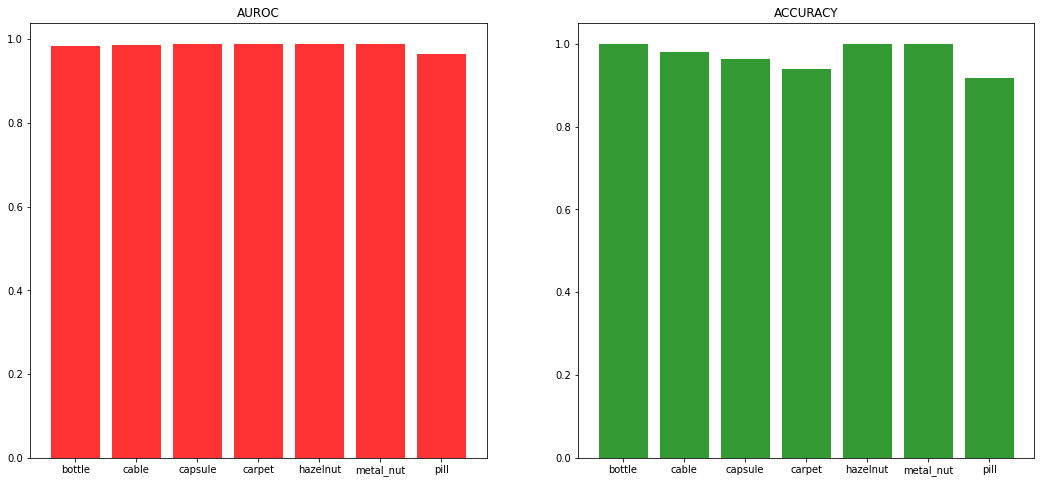

In [ ]:
show_bar(results)

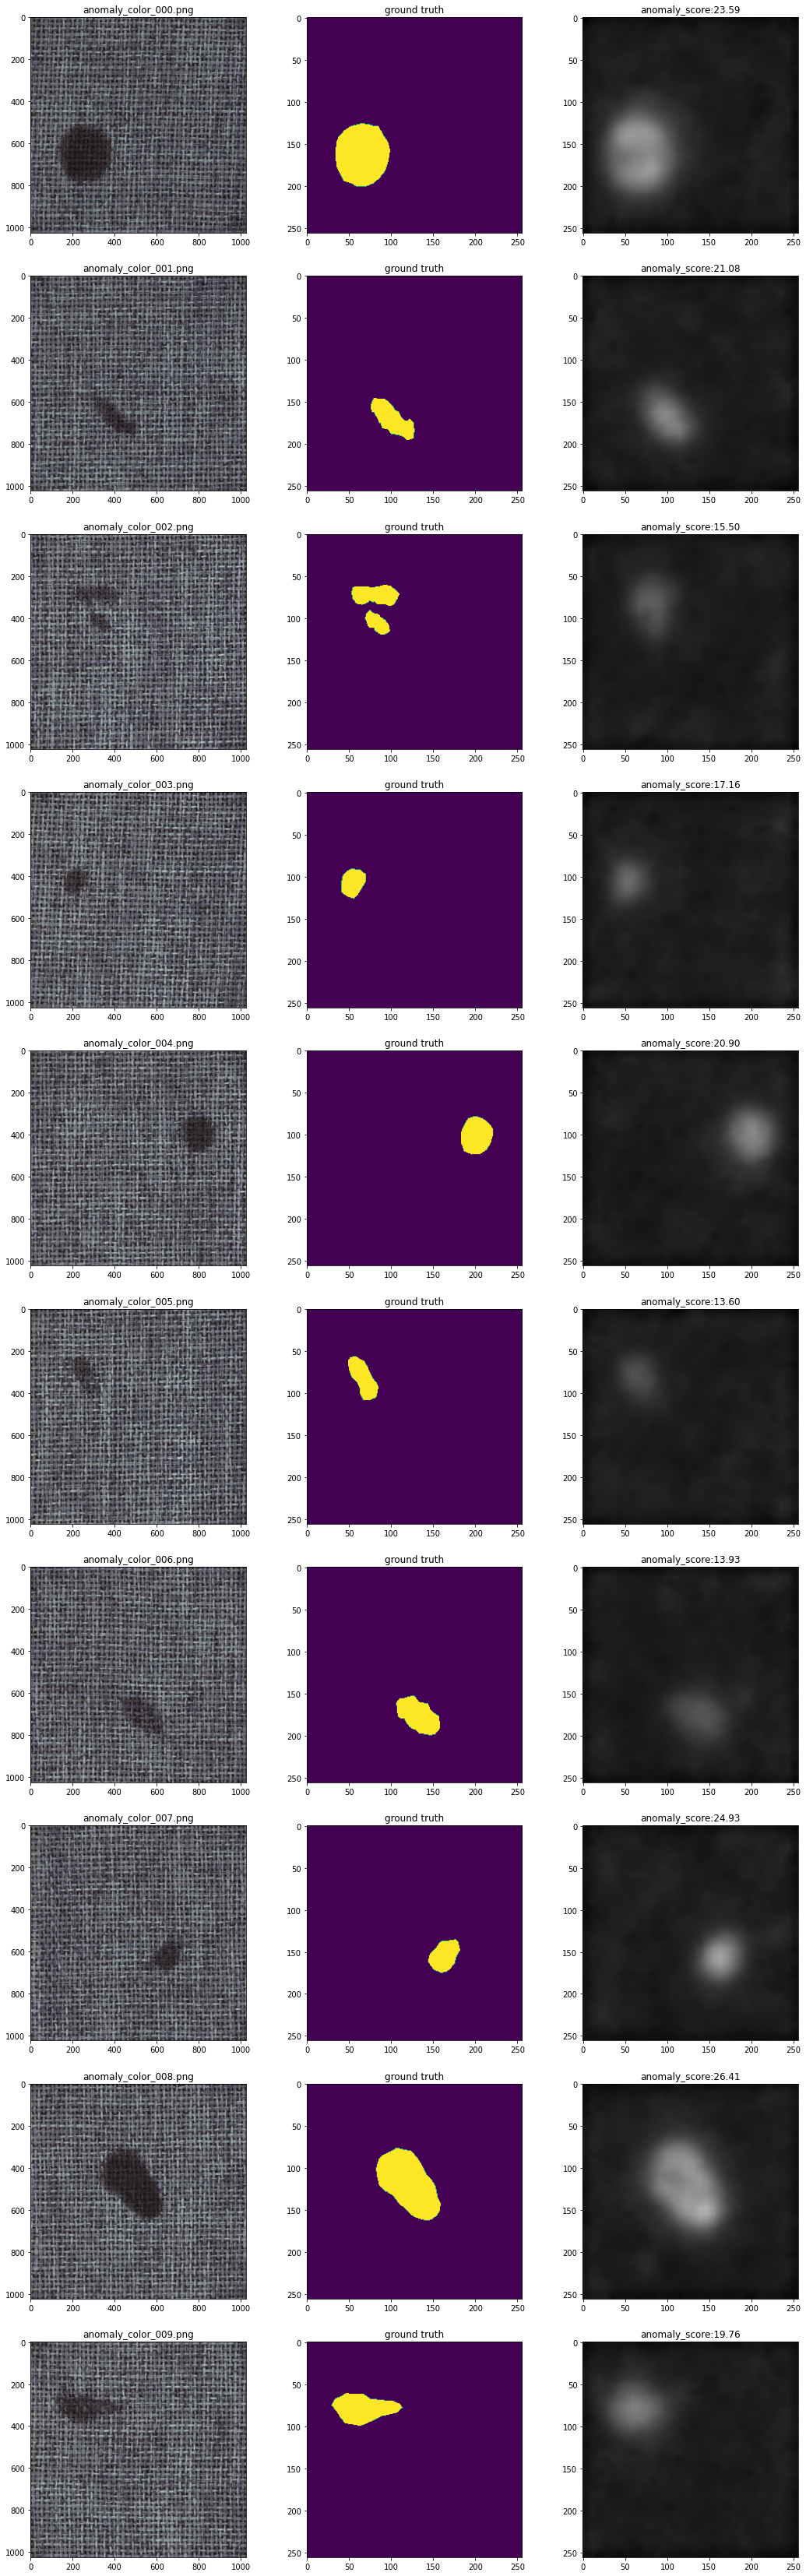

In [ ]:
show_result_image(results["carpet"], num=10)